In [15]:
import pydicom
import glob
import numpy as np
import sys
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import nibabel as nib

In [22]:
def which_computer_folder(which_computer: str):
    if which_computer == "home":
        datafolder = "C:/Users/Heris/OneDrive/Dokumenter/data/LIDC-IDRI/LIDC-IDRI-0001"
        outputfolder = "C:/Users/Heris/OneDrive/Dokumenter/data/OUTPUT/LIDC-IDRI-0001"
    elif which_computer == "mmiv":
        datafolder = "/home/heris/data/LIDC-IDRI/LIDC-IDRI-0001"
        outputfolder = "/home/heris/data/OUTPUT/LIDC-IDRI/LIDC-IDRI-0001"
    elif which_computer != "home" or which_computer != "mmiv":
        raise ValueError
    return datafolder, outputfolder
        


In [17]:
# datafolder , outputfolder = which_computer_folder("mmiv")
datafolder , outputfolder = which_computer_folder("home")


In [18]:
files = []
for root, dirs, the_files in os.walk(datafolder):
    # len(dirs) = 0 tells us that we're in the final folder, and 
    # len(the_files) >= 10 tells us that we only want to look at folders with more than 10 images, 
    # CT is usually only the ones that have that many images 
    """ path = root + "/" + the_files
    if os.path.isdir(path):
        continue

    if os.path.isfile(path):
        try: 
            dicom = pydicom.dcmread(path)
            print(dicom.Modality)

            files.append(dicom)
        except Exception as e: 
            continue
    """
    if len(dirs) == 0 and len(the_files) >= 10:
        for i in range(len(the_files)):
            if os.path.isfile(root+"/"+the_files[i]): 
                try: 
                    dicom = pydicom.dcmread(root+"/"+the_files[i])
                    files.append(dicom)
                except Exception as e: 
                    continue




In [19]:
# make sure we only keep data that has the same shape as the first slice
files = [a for a in files if a.get("PixelData") != None and a.pixel_array.shape == files[0].pixel_array.shape]

print("file count: {}".format(len(files)))

# make sure we sort the slices by SliceLocation or, if that does not exist by InstanceNumber
def sortFunc(s):
    if "SliceLocation" in s:
        return s.SliceLocation
    else:
        if "InstanceNumber" in s:
            return s.InstanceNumber
        return 0
slices = sorted(files, key=sortFunc)

file count: 133


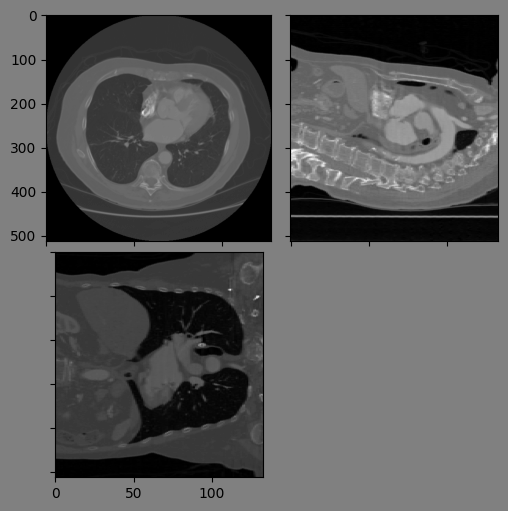

In [20]:
# pixel aspects, assuming all slices are the same
ps = slices[0].get("PixelSpacing", [1,1])
ss = slices[0].get("SliceThickness",1)
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ps[0]/ss

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d
#Saving the array as a NIfTI-file 
#NB: Look at header information 
nifti_image = nib.Nifti1Image(img3d, affine = np.eye(4))


# plot 3 orthogonal slices
fig=plt.figure(figsize=(6,6))
fig.patch.set_facecolor('gray')
gs1 = gridspec.GridSpec(2,2)
gs1.update(wspace=0.025, hspace=0.05)

a1 = plt.subplot(gs1[0])
plt.imshow(img3d[:, :, img_shape[2]//2], cmap='gray')
a1.set_aspect(ax_aspect)
a1.set_xticklabels([])

a2 = plt.subplot(gs1[1])
plt.imshow(img3d[:, img_shape[1]//2, :], cmap='gray')
a2.set_aspect(sag_aspect)
a2.set_xticklabels([])
a2.set_yticklabels([])

a3 = plt.subplot(gs1[2])
plt.imshow(img3d[img_shape[0]//2, :, :], cmap='gray')
a3.set_aspect(cor_aspect)
a3.set_yticklabels([])

plt.show()


NIfTI storage in the outputfolder

In [21]:
nib.save(nifti_image,outputfolder+"/LIDC-IDRI-0001")

Outputfolder